_Bastien Zimmermann_

Created in the lecture _Organizacion de datos_ de la Universidad de Buenos Aires

---
# Data Visualization

The aim of this notebook is to explore this dataset through graphical visualization. 

---
## Introduction:

To begin with the dataset to be explored consists of properties for sale in Mexico between 2012 and 2016 all prices are in Mexican pesos. We have no further information apart from the dataset csv file.

This exploration intends to go in depth through different aspects of the data. Not only exploring it through the saling price perpective but also highlighting some specificities of the dataset. 

As we have a priori little to no informations, it is needed to first off know more precisely what the dataset is about: 
 - What kind of information do we dispose
 - Is the dataset clean i.e. does it contains invalid inputs or too many null values
 - How spread are the datapoints i.e. what is a property or are the properties only in Mexico
 
Then we will be able to move on to in depth analysis:
 - Are there some interesting data patterns
 - What can we infer from certains data paterns
 - Extracting valuable information

---


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import scipy.stats as stats
import seaborn as sns
from datetime import datetime
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc, col, count, isnan, lit, sum
from pyspark.sql.functions import col, count, isnan, lit, sum
  
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import squarify

from colour import Color
from cartopy.io import shapereader
import geopandas
import cartopy.crs as ccrs

import folium
from folium.plugins import HeatMap

In [2]:
#cell to toogle hide code cells
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

---
## Property sells
---

_The dataset is focused on housing, hence the saling price is paramount. 
Let's begin with an overview of the data highlighting the price variable and its interactions._


In [3]:
data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("id", IntegerType(), False), \
    StructField("titulo", StringType(), True), \
    StructField("descripcion", StringType(), True), \
    StructField("tipodepropiedad", StringType(), True), \
    StructField("direccion", StringType(), True), \
    StructField("ciudad", StringType(), True), \
    StructField("provincia", StringType(), True), \
    StructField("antiguedad", DoubleType(), True), \
    StructField("habitaciones", DoubleType(),  True), \
    StructField("garages", DoubleType(),  True), \
    StructField("banos", DoubleType(),  True), \
    StructField("metroscubiertos", DoubleType(), True), \
    StructField("metrostotales", DoubleType(), True), \
    StructField("idzona", DoubleType(), True), \
    StructField("lat", DoubleType(), True), \
    StructField("lng", DoubleType(), True), \
    StructField("fecha", StringType(),  True), \
    StructField("gimnasio", DoubleType(),  True), \
    StructField("usosmultiples", DoubleType(), True), \
    StructField("piscina", DoubleType(), True), \
    StructField("escuelascercanas", DoubleType(), True), \
    StructField("centroscomercialescercanos", DoubleType(),  True), \
    StructField("precio", DoubleType(),  True)
])

In [5]:
df = sqlContext.read.csv('./train.csv', header=True, schema=data_schema, multiLine = True)

In [6]:
#Load the data
trainDF = pd.read_csv('./train.csv')
train = trainDF.sample(1000)

In [7]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng                           116512 non-null float64
fecha                         240

In [8]:
train.head(1)

id                                         titulo  \
30154  146361  puerto vallarta, jalisco. residencia en venta   

                                             descripcion tipodepropiedad  \
30154  <p>puerto vallarta. jalisco, mexico.espectacul...            Casa   

                  direccion           ciudad provincia  antiguedad  \
30154  paseo del marlin 146  Puerto Vallarta   Jalisco         3.0   

       habitaciones  garages  ...   idzona        lat         lng  \
30154           4.0      3.0  ...  50938.0  20.633459 -105.221626   

                     fecha  gimnasio  usosmultiples piscina  escuelascercanas  \
30154  2014-02-19 00:00:00       1.0            1.0     1.0               1.0   

       centroscomercialescercanos     precio  
30154                         1.0  7190000.0  

[1 rows x 23 columns]

#### This dataset is about selling houses, hence : The most important column of the dataset is the sale price. 

However a broad look at the data is often needed.

Let's have a look at the price distribution:

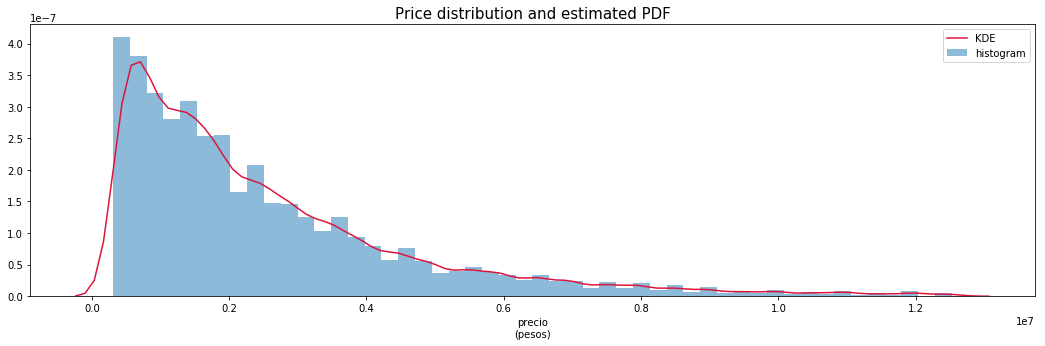

+-------+------------------+
|summary|            precio|
+-------+------------------+
|  count|            240000|
|   mean|2530838.3458958333|
| stddev|2152551.7976219207|
|    min|          310000.0|
|    max|          1.2525E7|
+-------+------------------+

The skewness in Sale price is : 1.70201
The Kurtosis in Sale price is : 3.23109


In [8]:
plt.figure(figsize = [18,5])
#sns.distplot(train['precio'],label ='density estimation')
sns.distplot(trainDF['precio'],kde_kws={"color": "crimson", "label": "KDE"},
             hist_kws={"linewidth": 3, "alpha": 0.5,"label" : "histogram"})
plt.title('Price distribution and estimated PDF', fontsize = 15)
plt.xlabel('precio\n(pesos)')
plt.legend()
plt.show()
df.select('precio').describe().show()

print('The skewness in Sale price is : %.5f'%trainDF['precio'].skew())
print('The Kurtosis in Sale price is : %.5f'%trainDF['precio'].kurt())

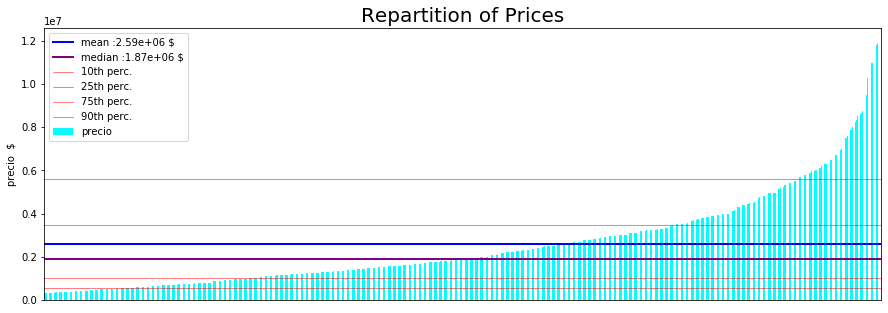

+-------+------------------+
|summary|            precio|
+-------+------------------+
|  count|            240000|
|   mean|2530838.3458958333|
| stddev|2152551.7976219207|
|    min|          310000.0|
|    max|          1.2525E7|
+-------+------------------+

The skewness in Sale price is : 1.70201
The Kurtosis in Sale price is : 3.23109


In [9]:
fig, ax = plt.subplots(figsize=[15,5])

train['precio'].sort_values().plot(kind='bar', ax = ax, xticks=None, cmap='cool')
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)

plt.axhline(train['precio'].mean(),c = 'b', linewidth = 2, label = "mean :" + "%.2e"%train['precio'].mean()+ " $")
plt.axhline(train['precio'].median(),c = 'purple', linewidth = 2, label = "median :" + "%.2e"%train['precio'].median()+ " $")

for i, quantile in enumerate([.1, 0.25, .75, .9]):
    ax.axhline(train['precio'].quantile(quantile), label='%.0fth perc.' % (quantile*100), color = 'r', linewidth = 0.5)
    
plt.ylabel("precio  $")
plt.legend()
plt.title('Repartition of Prices',fontsize = 20)
plt.show()
df.select('precio').describe().show()
print('The skewness in Sale price is : %.5f'%trainDF['precio'].skew())
print('The Kurtosis in Sale price is : %.5f'%trainDF['precio'].kurt())

The two preceeding graph inform us that the price distribution is staked towards the lower prices, and is does not seem to follow a normal distribution. Most models are created assuming normalized data as nature seems to follow this distribution (for most fenomenom). Our data will need most likely need some pre-processing such as a log transform in order to increase model preformance.

#### Let's see the impact of each columns and their relations.

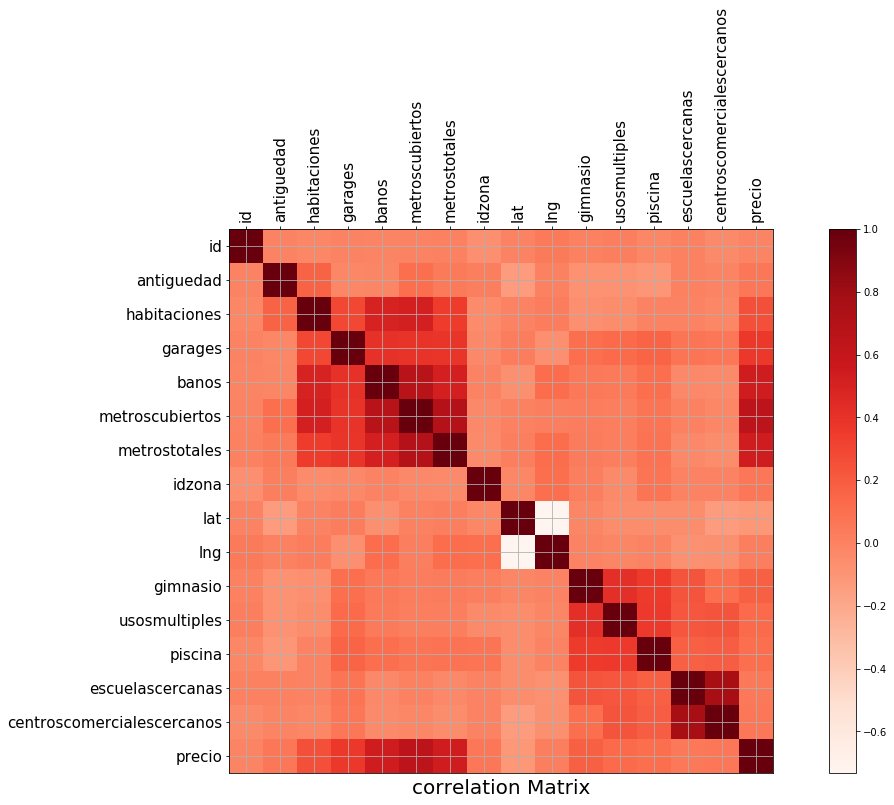

In [10]:
cor = train.corr()
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))


fig, ax = plt.subplots(figsize=[20,10])

plt.title("correlation Matrix", fontsize = 20, y=-0.05)
image = ax.imshow(cor, cmap = 'Reds')#'Greys','hsv')

plt.xticks(np.arange(len(cor.columns)),cor.columns, rotation = 'vertical', fontsize = 15)
ax.xaxis.tick_top()
plt.yticks(np.arange(len(cor.columns)),cor.columns, rotation = 'horizontal', fontsize = 15)
fig.colorbar(image, ax=ax)
plt.rcParams['grid.color'] = "w"
plt.grid()
plt.show()

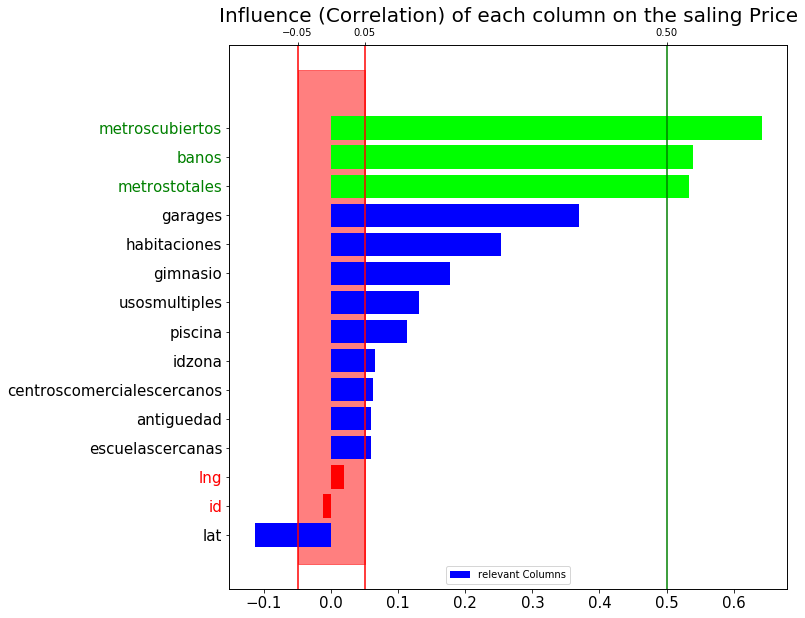

In [11]:
#order the correlations and their associated column
minCorrValue = 0.05
goodCorrValue = 0.5

corrOrdered = list(upper['precio'].copy().sort_values())
numNan = upper['precio'].isnull().sum()
colOrdered = [upper.columns[list(upper['precio']).index(x)] for x in corrOrdered[:-numNan]]

# We have colOrdered, corrOrdered, numNan, lowCorrelatedColumns

lowCorrelatedColumns, highCorrelatedColumns = [], []

#get the high and low correlated columns + color
colorList= ['b']*len(colOrdered)
for x in corrOrdered:
    if abs(x) in [x for x in list(upper['precio'].abs()) if x<minCorrValue]:
        colorList[corrOrdered.index(x)] = 'r'                    #undecoralated columns are red
        lowCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
    if abs(x) in [x for x in list(upper['precio'].abs()) if x>goodCorrValue]:
        colorList[corrOrdered.index(x)] = 'lime'                    #undecoralated columns are red
        highCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
                        
            
plt.figure(figsize=[10,10])
plt.barh(colOrdered,corrOrdered[:-numNan], color=colorList)
plt.title("Influence (Correlation) of each column on the saling Price", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend( ['relevant Columns','good'])
plt.axvline(x= minCorrValue, c='r')
plt.fill_between([-minCorrValue,minCorrValue], [len(upper),len(upper)],[-1,-1], alpha = 0.5, color = 'red')
plt.axvline(x= -minCorrValue, c='r')
plt.axvline(x= goodCorrValue, c='g')
ax = plt.gca()
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-minCorrValue,minCorrValue,goodCorrValue])

#color the yticks
for x in lowCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("red")
for x in highCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("green")

plt.show()
#print("Low correlatedColumns", lowCorrelatedColumns)

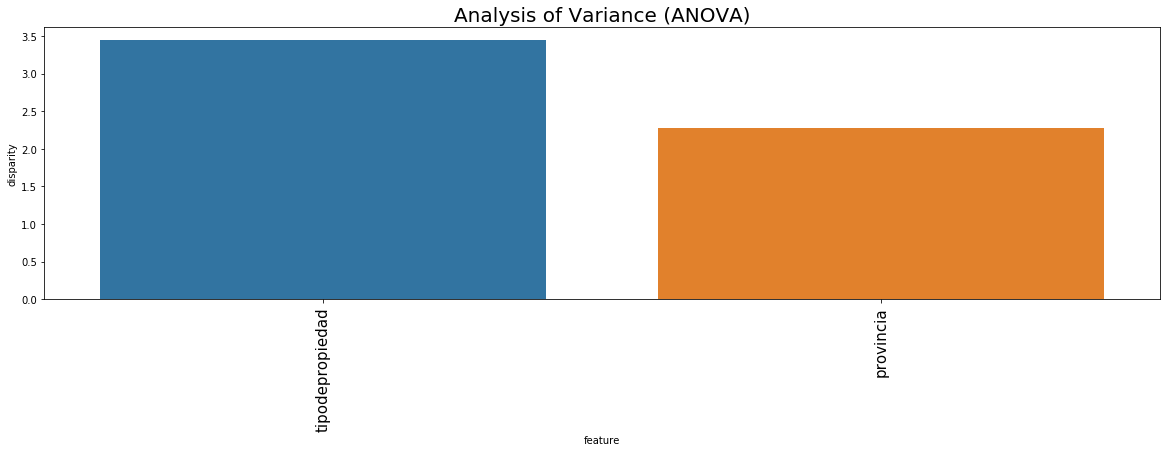

In [12]:
qualitative = train.select_dtypes('object').columns

qualitativeImportant = ['tipodepropiedad','provincia']
qualitative = qualitativeImportant
plt.figure(figsize = [20,5])
anovaDF = train.copy().dropna()
anova = pd.DataFrame(columns = ['feature','pvalue'])
anova['feature'] = qualitativeImportant
for col in qualitativeImportant: #for each qualitative column we get the pvalues
    samples = []
    for elt in anovaDF[col].unique():
        samples.append(anovaDF['precio'][anovaDF[col] == elt].values)
    a = stats.f_oneway(*samples)
    anova['pvalue'][anova['feature']==col] = a.pvalue
    
#sort and cast
anova = anova.sort_values('pvalue')
anova['pvalue'] = anova['pvalue'].astype('float')
#transform for better visualisation and plot
anova['disparity'] = np.log(1./anova['pvalue'].values)
sns.barplot(data=anova, x='feature', y='disparity')
x=plt.xticks(rotation=90, fontsize = 15)
plt.title('Analysis of Variance (ANOVA)', fontsize = 20)
plt.show()

The different analysis of variances, corelletion inform us on several points. The correlation matrix shows that some columns can be redundant such as metros cubiertos and metrototales. The second plot ranks the direct importance of each columns on the saling price(those with quantitive values). At last the analysis of variance indicate that knowing the province in wich the sale occur has more impact on the price than the property type. 

---
## __Now let's dig into this and examine closely the impact of factors on the saling price.__
---

_Starting with the impact of time on data_

In [13]:
dayByMonth = [31,27,31,30,31,30,31,31,30,31,30,31]
daysList = ['mon','tue','wed','thu','fri','sat','sun']
#format date columns
#cast to datetime type
trainDF['Date'] = trainDF['fecha'].apply(func = (lambda x :(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))))
trainDF['year'] = trainDF['Date'].apply(func = (lambda t : int(t.year)))
trainDF['dayOfYear'] = trainDF['Date'].apply(func = (lambda t : int(t.day+np.sum(dayByMonth[:t.month-1]))))

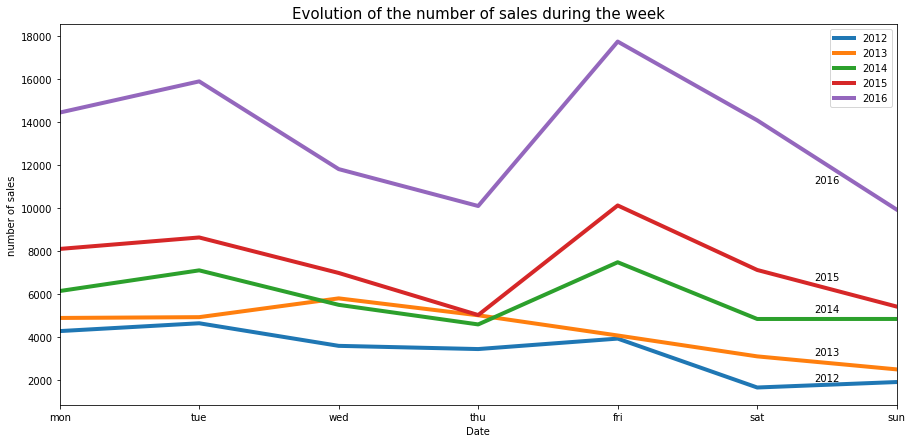

In [14]:
fig, ax = plt.subplots(figsize=(15,7))
trainDF.groupby([trainDF['Date'].apply(func = (lambda t : t.weekday())),'year']).count()['precio'].unstack().plot(ax=ax, label = daysList,linewidth=4)
plt.ylabel('number of sales')
plt.xticks(np.arange(7),daysList)
#fancy annotations
plt.annotate('2016', (5.5,10700), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2015', (5.5,6200), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2014', (5.5,4700), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2013', (5.5,2700), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2012', (5.5,1500), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()
plt.title('Evolution of the number of sales during the week', fontsize = 15)
plt.grid(True)
plt.rc('grid', linestyle="-", color='black', alpha = 0.2)
plt.show()

The number of sales trend seems steady for the past 3 years. 
The most productive days are the tuesdays and fridays, on the other side their is logicaly less sales during the weekends.

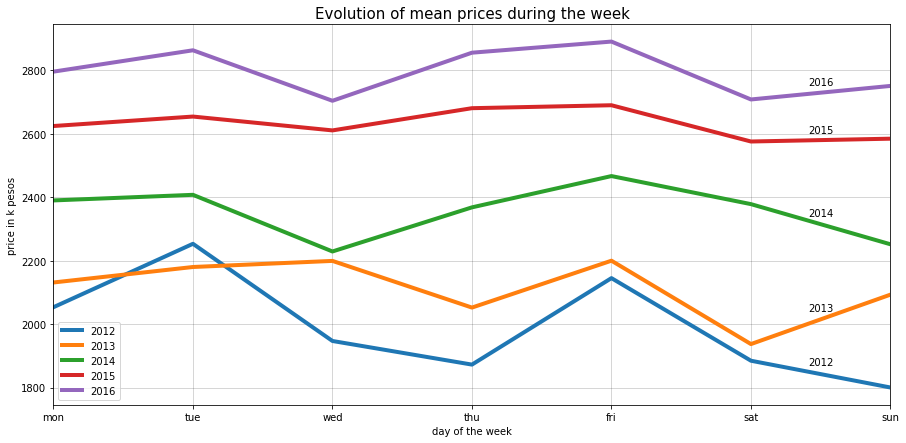

In [15]:
fig, ax = plt.subplots(figsize=(15,7))
temp = trainDF.groupby([trainDF['Date'].apply(func = (lambda t : t.weekday())),'year']).mean()['precio']/10**3
temp.unstack().plot(ax=ax, label = daysList,linewidth=4)
plt.xticks(np.arange(7),daysList)
#fancy annotations
plt.annotate('2016', (5.5,2720), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2015', (5.5,2570), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2014', (5.5,2310), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2013', (5.5,2010), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('2012', (5.5,1840), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()
plt.ylabel('price in k pesos')
plt.xlabel('day of the week')
plt.title('Evolution of mean prices during the week', fontsize = 15)
plt.grid(True)
plt.rc('grid', linestyle="-", color='black', alpha = 0.2)
plt.show()

- The best day to buy a property was the wednesday in 2016, however there is no clear trend. 


- On average the highest prices are found the tuesdays and fridays nearly each year.


- The inflation is easily seen, as each year both number of sells and mean prices rize.


---


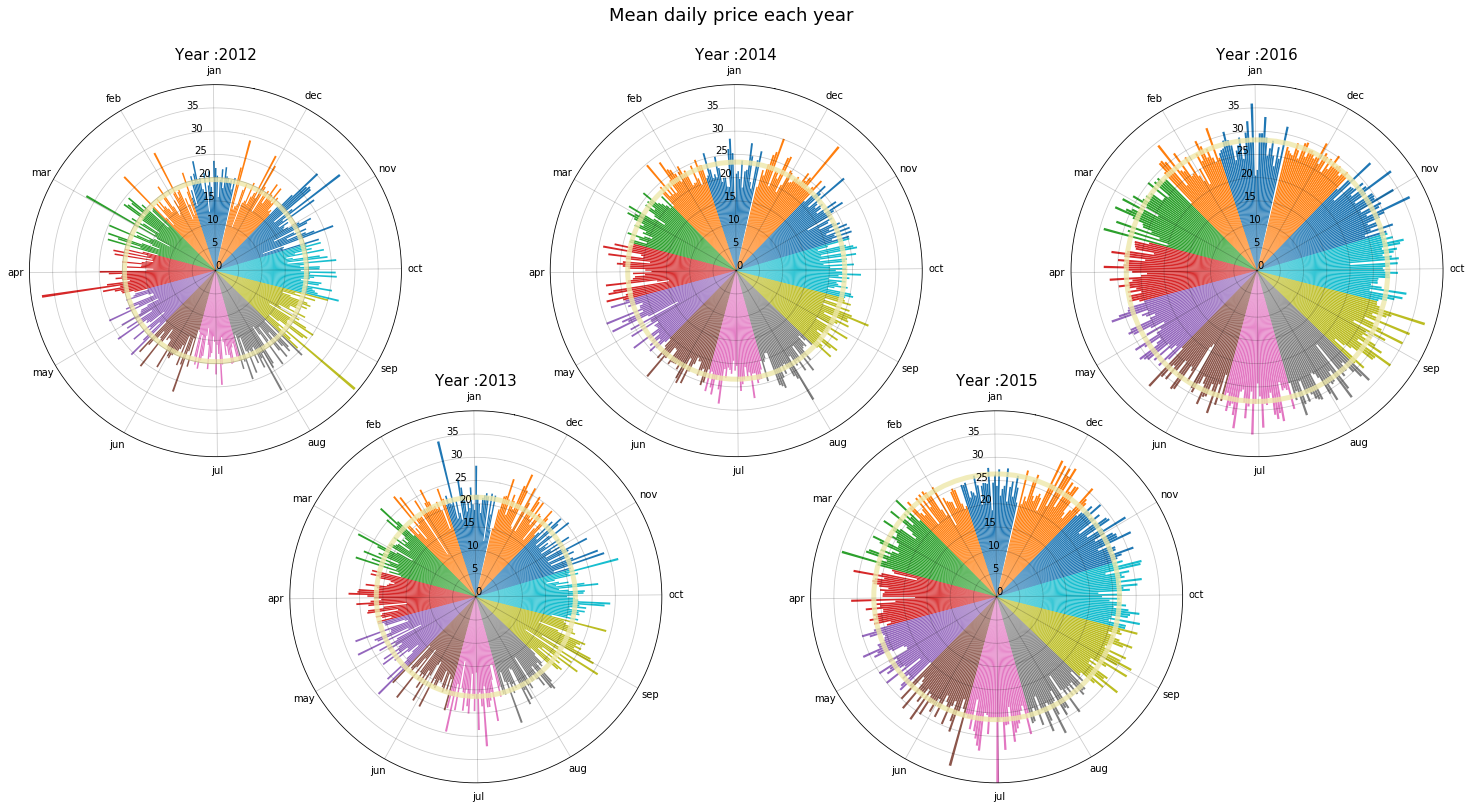

In [16]:
monthList = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

fig= plt.figure(figsize = [30,30])
grid = plt.GridSpec(2, 6)

for year in range(2012,2017):
    #get yearly data
    res = trainDF[trainDF['year']==year].groupby('dayOfYear').mean().sort_values('dayOfYear', ascending=True).precio/10**5
    
    resultList = [[]]*12
    i = 0
    k = 0
    for x in dayByMonth:
        resultList[k] = res.iloc[i:i+x].values
        k+=1
        i+=x
        
    #organize subplots
    index = year-2011
    if(index in [1,3,5]):
        index = int((index+1)/2)
        ax = fig.add_subplot(grid[0,((index-1)%4)*2:(((index-1))%4)*2+1], projection='polar')
    else:
        index = int(index/2+3)
        ax = fig.add_subplot(grid[1,(index%4)*2+1:((index)%4+1)*2], projection='polar')
    
    #plot
    ax.set_xticks((np.arange(12)*(2*np.pi)/12)+0.22)#set xticks location to be corresponding with the months
    ax.set_xticklabels(monthList)
    #set a comon y scale
    ax.set_ylim(0,40)
    ax.set_yticks(np.arange(0,40,5))
    ax.set_theta_zero_location('N',-12)
    plt.title("Year :"+str(year), fontsize = 15)
    offset=0

    circle = plt.Circle((0, 0), np.mean(res), transform=ax.transData._b, color="palegoldenrod",
                        alpha=0.8, fill = False,label='mean',linewidth =5)
    ax.add_artist(circle)
    for i in range(12):
        newOffset = offset+len(resultList[i])
        theta = np.linspace((2*np.pi)*offset/365, (2*np.pi)*newOffset/365, len(resultList[i]), endpoint=False)
        offset = newOffset
        ax.bar(theta, resultList[i], width = np.ones(len(resultList[i]))*0.015)

plt.suptitle("Mean daily price each year", y = 0.7, x = 0.45, fontsize = 18)
plt.subplots_adjust(hspace = -0.75,wspace = -0.3)
plt.show()

_Prices by day of the year and month_

Here we can clearly see the inflation each year, the mean sales progress. Furthermore some days are highlighted having some extraordinary values, we can use that as an indicator of certains events such as the 2014 may earthquake

In [17]:
res = trainDF.groupby('dayOfYear').mean().sort_values('dayOfYear', ascending=True).precio
resultList = [[]]*12
i = 0
k = 0
for x in dayByMonth:
    resultList[k] = res.iloc[i:i+x].values
    k+=1
    i+=x

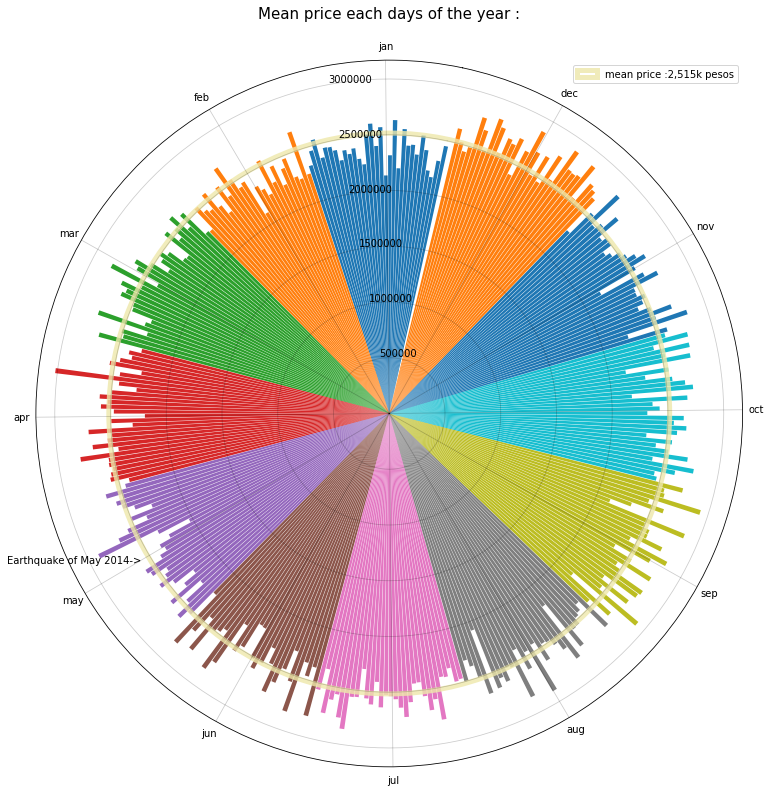

The best day to buy a property was the 13 May
The worst day to buy a property was the 07 April


In [18]:

#plot, round layout
plt.figure(figsize=[13,13])
ax = plt.subplot(111, polar=True)
ax.set_xticks((np.arange(12)*(2*np.pi)/12)+0.22)#set xticks location to be corresponding with the months
ax.set_xticklabels(monthList)
ax.set_theta_zero_location('N',-12)
plt.title("Mean price each days of the year :", fontsize = 15)
offset=0

circle = plt.Circle((0, 0), np.mean(res), transform=ax.transData._b, color="palegoldenrod",
                    alpha=0.8, fill = False,label='mean',linewidth =5)
ax.add_artist(circle)

ax.legend([circle], ['mean price :'+"{:,d}".format(int(np.mean(res)/10**3))+'k pesos'])
for i in range(12):
    newOffset = offset+len(resultList[i])
    theta = np.linspace((2*np.pi)*offset/365, (2*np.pi)*newOffset/365, len(resultList[i]), endpoint=False)
    offset = newOffset
    ax.bar(theta, resultList[i], width = np.ones(len(resultList[i]))*0.015)
    
plt.annotate('Earthquake of May 2014->', ((2*np.pi/12)*4.3,3170000), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

#print valuable information
print('The best day to buy a property was the',datetime.strptime('2014 '+
                         str(res[res.values == min(res)].index[0]), '%Y %j').strftime('%d %B'))
print('The worst day to buy a property was the',datetime.strptime('2014 '+
                         str(res[res.values == max(res)].index[0]), '%Y %j').strftime('%d %B'))

In [19]:
print("How far were the lowest and highest prices from the mean each year : ")
minPrice = trainDF[trainDF['dayOfYear']==res[res.values == min(res)].index[0]][['year','precio']].groupby('year').mean()
meanPrice = trainDF[['year','precio']].groupby('year').mean()
maxPrice = trainDF[trainDF['dayOfYear']==res[res.values == max(res)].index[0]][['year','precio']].groupby('year').mean()
minPrice.columns = ['min']
meanPrice.columns = ['mean']
maxPrice.columns = ['max']
minPrice['year']=minPrice.index
meanPrice['year']=meanPrice.index
maxPrice['year']=maxPrice.index
minPrice.index = np.arange(5)
meanPrice.index = np.arange(5)
maxPrice.index = np.arange(5)
testres = pd.concat([pd.concat([minPrice, maxPrice], axis= 1),meanPrice],axis=1)
testres.index = meanPrice['year'].values
testres = testres/10**6
testres = testres.drop(columns=['year'])
testres['difMin']=testres['mean']-testres['min']
testres['difMax'] = -testres['mean']+testres['max']
testres[['difMin', 'difMax']]

How far were the lowest and highest prices from the mean each year : 


difMin    difMax
2012  0.221840 -0.516056
2013  0.202965 -0.195756
2014  0.937183  0.408439
2015  0.373904  0.053315
2016  0.212533  0.354985

With this table we see that the day with the lowest prices in 2014 was significantly lower and in any other year. Hence a special event must have occured arround that day.

8 may 2014 -> eathquake

5 avril 2014 ->  Brasil and Mexico?

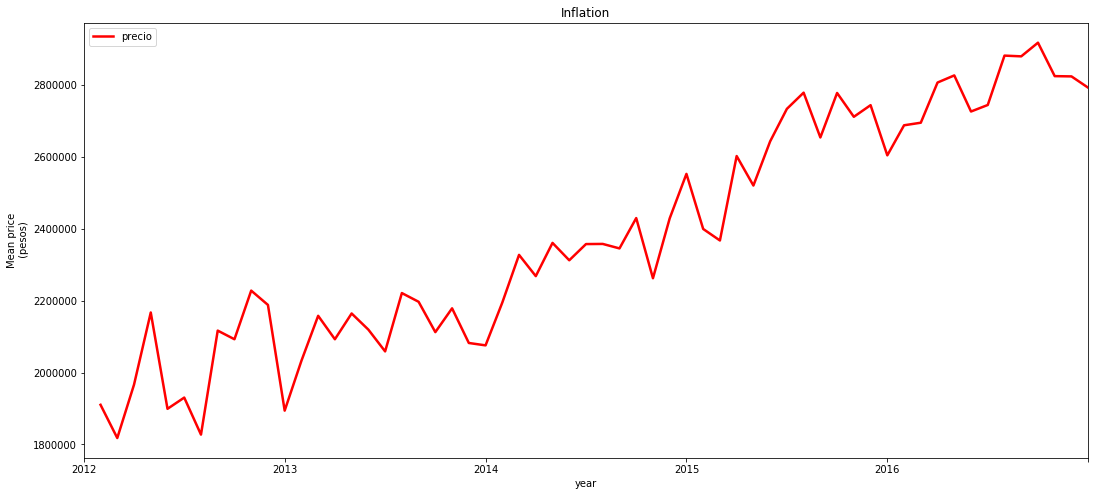

In [20]:
#plt.
trainDF[['precio']].groupby(trainDF['Date'].apply(func = (lambda t : (t.year-2012)*12+t.month)))\
            .mean().plot(c='r',linewidth =2.5, figsize = [18,8])
plt.title('Inflation')
plt.xticks(np.arange(0,61,12),np.arange(2012,2017,1))
plt.xlabel('year')
plt.ylabel('Mean price\n (pesos)')
plt.show()

As stated before the inflation is positive and steady. Each year the prices rise following a steady trend.

---
## __PCA__
---
_Doing a principal component analysis is efficient to visualize data and correlation. However one must keep in mind that the axis do not represent any of the variables and have no tangible meaning as they are combining variables that might have nothing to do one with another._


In [21]:
#select the columns for the pca
quantitative = list(trainDF.select_dtypes('number').columns)
pcaDF = trainDF[quantitative].copy()
quantitative.remove('id')
quantitative.remove('precio')

#PCA pre-processing -> normalizing
x = pcaDF[quantitative].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pcaDF[quantitative] = pd.DataFrame(x_scaled)

#Do not preprocess the price
quantitative.append('precio')

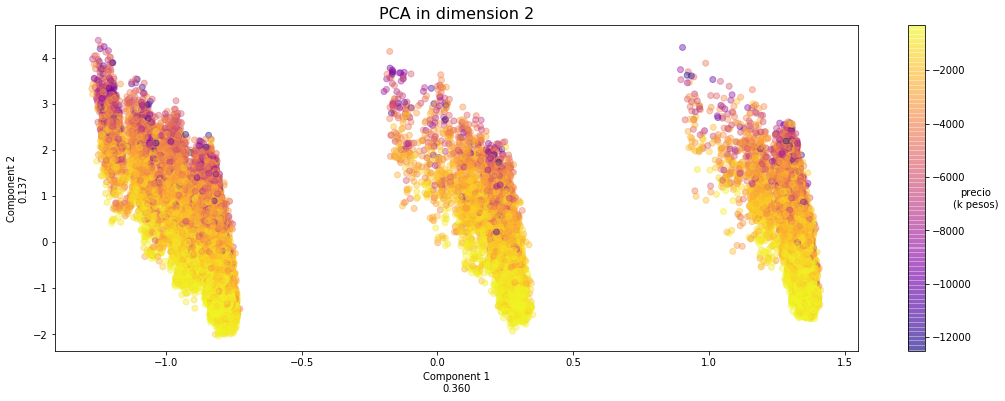

In [22]:
pca = PCA(n_components=2, whiten=True)
dfPCA = pcaDF[quantitative].dropna()
X = dfPCA.drop(columns =['precio'])
pca.fit(X)

plt.figure(figsize = [18,6])
# plot principal components
X_pca = pca.transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.4,c=-dfPCA['precio']/10**3, cmap= 'plasma')
plt.xlabel('Component 1\n%.3f'% pca.explained_variance_ratio_[0])
plt.ylabel('Component 2\n%.3f'% pca.explained_variance_ratio_[1])
plt.title('PCA in dimension 2',fontsize = 16)
cbar = plt.colorbar()
cbar.set_label('precio\n(k pesos)', rotation = 0)
plt.show()

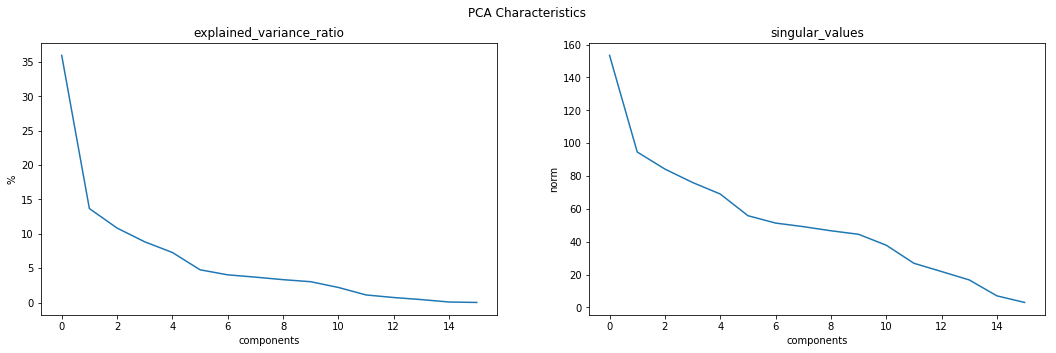

In [23]:
fig, ax = plt.subplots(ncols = 2, figsize = [18,5])

pca = PCA(n_components=len(X.columns), whiten=True)
pca.fit(X)

#explained_variance_ratio_
ax[0].plot(np.arange(len(X.columns)),pca.explained_variance_ratio_*100)
ax[0].set_title('explained_variance_ratio')
ax[0].set_ylabel('%')
ax[0].set_xlabel('components')
#singular_values_
ax[1].plot(np.arange(len(X.columns)),pca.singular_values_)
ax[1].set_title('singular_values')
ax[1].set_xlabel('components')
ax[1].set_ylabel('norm')

plt.suptitle('PCA Characteristics')
plt.show()

The explained variance ratio plot can help us when reducing the dimensionality of the data. It indicates of much each component impacts the saling price, by example we could prune the last 3 components as they explain less than 10 % of the variance.

_It is highly surprising that we find 3 very distinct clusters. The price follows more or less the second component with a shift along the first one._

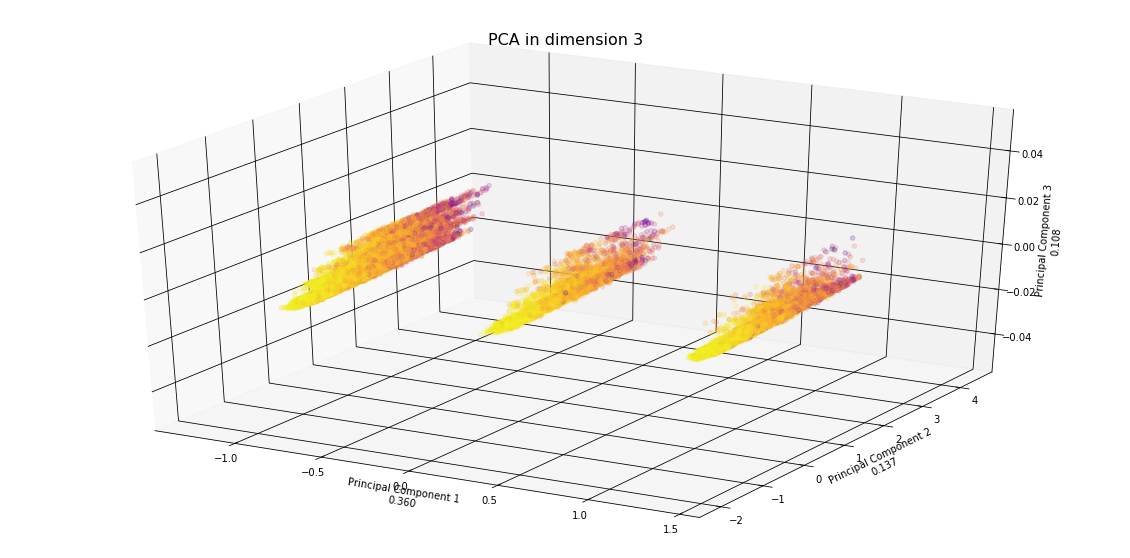

In [24]:
pca = PCA(n_components=3, whiten=True)
dfPCA = pcaDF[quantitative].dropna()
X = dfPCA.drop(columns =['precio'])
pca.fit(X)
X_pca = pca.transform(X)

threedee = plt.figure(figsize=[20,10]).gca(projection='3d')

# plot principal components
threedee.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2,c=-dfPCA['precio'], cmap= 'plasma')
threedee.set_xlabel('Principal Component 1\n%.3f'% pca.explained_variance_ratio_[0])
threedee.set_ylabel('Principal Component 2\n%.3f'% pca.explained_variance_ratio_[1])
threedee.set_zlabel('Principal Component 3\n%.3f'% pca.explained_variance_ratio_[2])
plt.title('PCA in dimension 3',fontsize = 16)
plt.show()

Judging form the up above results it seems that we have 3 separate but similar sets of data. When trying to infer a price of one property, we could first identify to which cluster our case fit and then use a model only trained on that set of data. Doing so would avoid our model to also learn the clustering analysis and that could lead to better performances.

The three groups can be separate categories such as :

- departemento
- terreno
- casa

---

## __Let's now tackle the impact of location on the saling price:__

1. by city
2. by geographical zone
3. by lat/lnt location

---


_Prices by cities_

In [25]:
topSellingCities = df.groupby('ciudad').count().orderBy('count', ascending=0).collect()[:15]
topVendingCities = df.groupby('ciudad').mean('precio').orderBy('avg(precio)', ascending=0).collect()[:15]

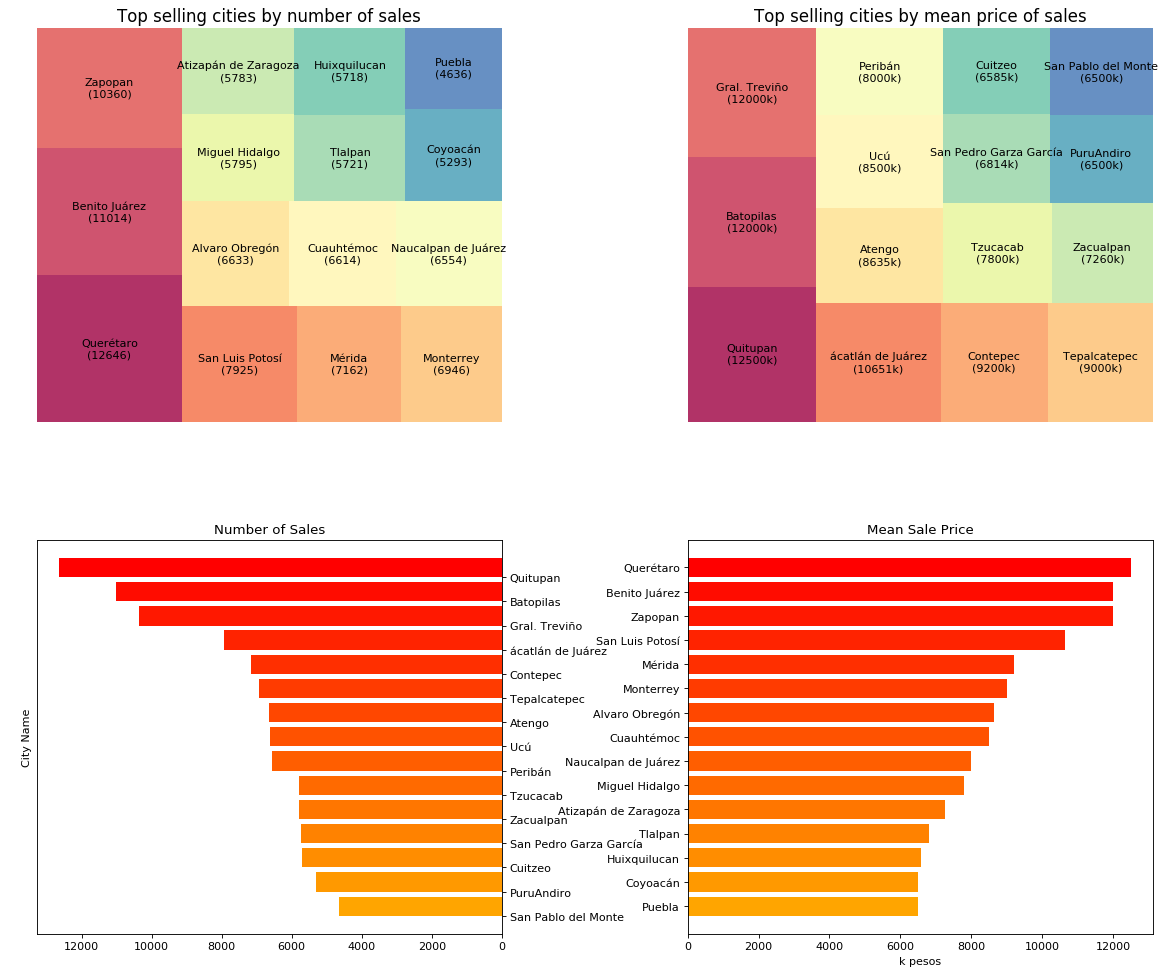

In [26]:
labelsNumber = [str(x[0])+'\n('+str(x[1])+')' for x in topSellingCities]
sizesNumber = [x[1] for x in topSellingCities]
labelsPrice = [str(x[0])+'\n('+str(int(x[1]/1000))+'k)' for x in topVendingCities]
sizesPrice = [x[1] for x in topVendingCities]

#colors for The area plots
colorsPrice = [plt.cm.Spectral(i/float(len(labelsPrice))) for i in range(len(labelsPrice))]
colorsNumber = [plt.cm.Spectral(i/float(len(labelsNumber))) for i in range(len(labelsNumber))]

#colors for the barPlot
red = Color("orange")
colors = list(red.range_to(Color("red"),len(sizesPrice)))
colors = [color.rgb for color in colors]


# Draw Plot
plt.subplots(nrows = 2, ncols = 3, figsize=(18, 15), dpi = 80)


grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)


plt.subplot(grid[0, 0])
squarify.plot(sizes=sizesNumber, label=labelsNumber, color=colorsNumber, alpha=.8)
plt.title('Top selling cities by number of sales', fontsize = 15)
plt.axis('off')
plt.xlabel('price in pesos')

plt.subplot(grid[0, 1])    
squarify.plot(sizes=sizesPrice, label=labelsPrice, color=colorsPrice, alpha=.8)
plt.title('Top selling cities by mean price of sales', fontsize = 15)
plt.axis('off')


ax = plt.subplot(grid[1:, 0])    
plt.title('Number of Sales')
topVendingCities.reverse(), sizesNumber.reverse()
plt.barh([str(x[0])for x in topVendingCities],sizesNumber,align = 'edge',color=colors)
ax.invert_xaxis()
plt.ylabel('City Name')
ax.yaxis.tick_right()

plt.subplot(grid[1:, 1])    
plt.title('Mean Sale Price')
topSellingCities.reverse(),sizesPrice.reverse()
plt.barh([str(x[0])for x in topSellingCities],[int(x/10**3) for x in sizesPrice], color=colors)#[\n'+str(pca.explained_variance_ratio_[0]) int(x/10**5) for x in sizesPrice])
plt.xlabel('k pesos')
# Decorate

plt.show()

- The cities with the most sales aren't the most expensive ones, that is once again showing that the price distribution is shifted towards low prices as the cities with most sales aren't the most expensive ones.  Most sales have a low price and that impact the mean sale price weighting is down.
- The 3 most expensive cities have a round mean sale price that might be because only one sell occured there, maybe for some exeptional properties.

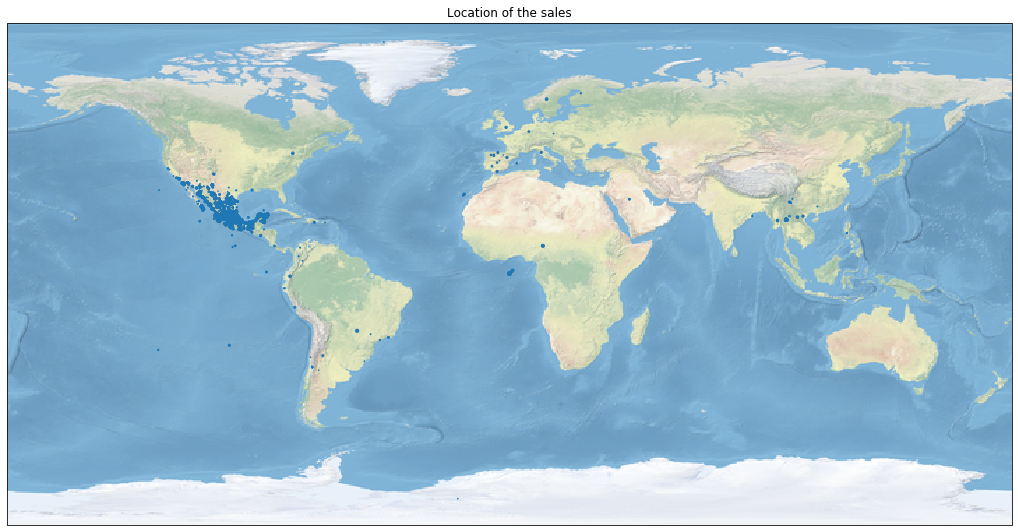

In [27]:
plt.figure(figsize = [18,20])
# just to show the problem in our data
ax = plt.axes(projection=ccrs.PlateCarree())
mapTrainDF = trainDF[['lat','lng','precio']].dropna()
mapTrainDF.plot(kind="scatter", x="lng", y="lat", s=mapTrainDF['precio']/10**6,
                title ='Location of the sales', ax = ax)
ax.stock_img()
plt.show()

Some of the sales are not located in Mexico, that can be because of several reasons. It might be a mistake in the data, however most of the point seem to be in relevant points (existing cities ex: London). Knowing a bit how the dataset was constituted, it seems to be that the point indicated do represent properties that were sold in Mexico, not necesarly properties located in Mexico. 

_Note: Those are a minority_

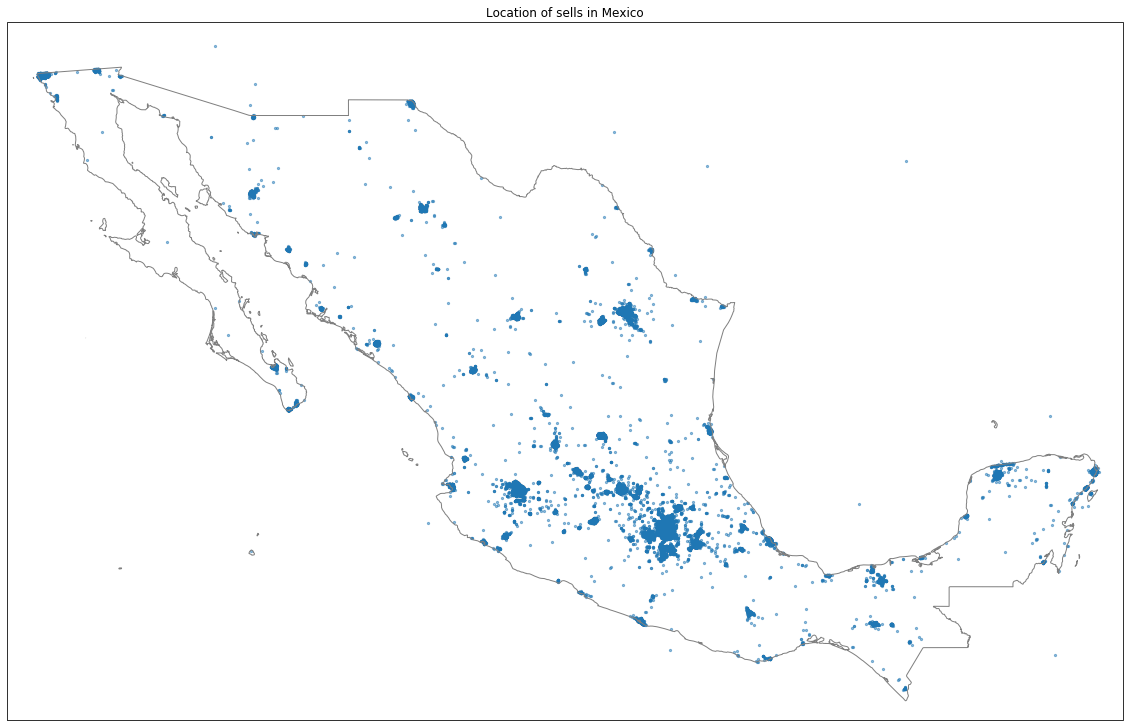

In [28]:
plt.figure(figsize = [20,15])
# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
geodf = geopandas.read_file(shpfilename)

# read the Mexican borders
poly = geodf.loc[geodf['ADMIN'] == 'Mexico']['geometry'].values[0]

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', 
                  edgecolor='0.5')
#plot the points we have
mapTrainDF.plot(kind="scatter", x="lng", y="lat",marker ='.', ax=ax, alpha=0.5,transform=ccrs.PlateCarree())
plt.title('Location of sells in Mexico')
#Set the map on mexico's location

ax.set_extent([-118, -86, 14, 34], crs=ccrs.PlateCarree())

The data seems to follow the population distribution in Mexico. We can pinpoint cities and urban areas.

In [29]:
#create a df for map data
mapTrainDF = mapTrainDF[['lat','lng','precio']]
#filter out the outliers -> not in Mexico
mapTrainDF = mapTrainDF[(np.abs(stats.zscore(mapTrainDF)) < 12).all(axis=1)]

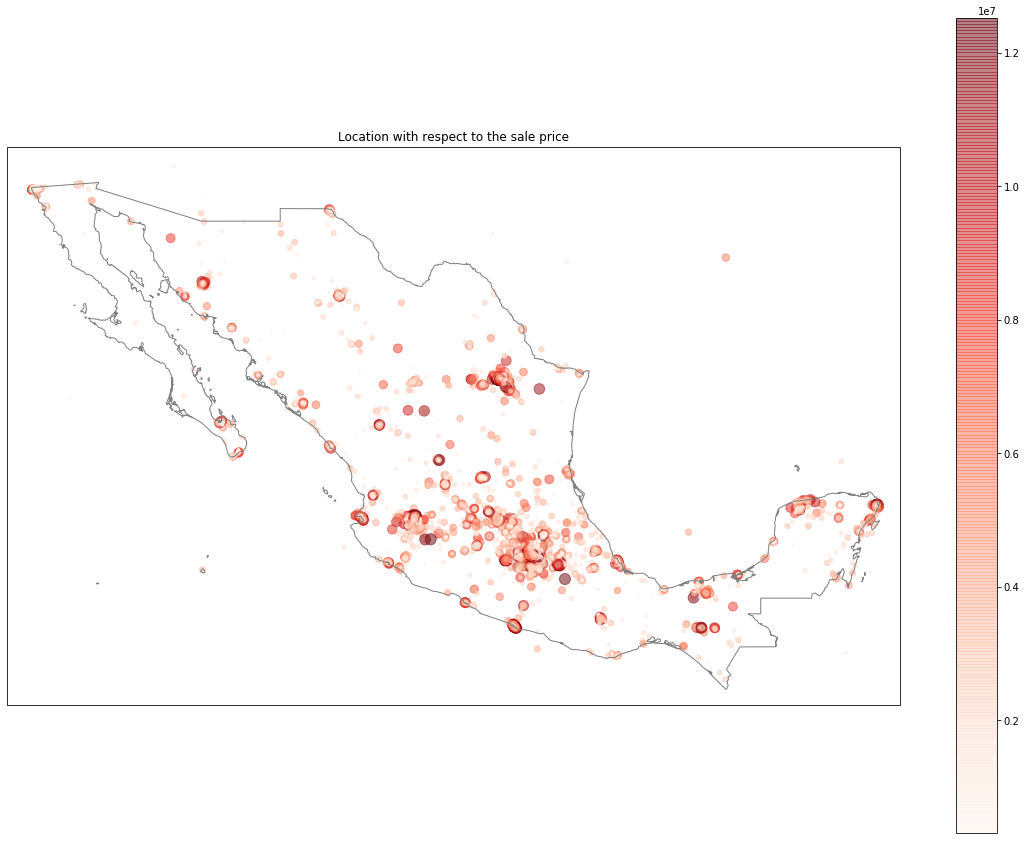

In [30]:
plt.figure(figsize = [20,15])

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', 
                  edgecolor='0.5')
#plot the points we have
mapTrainDF.plot(kind="scatter", x="lng", y="lat", s=mapTrainDF['precio']/10**5,
                 c = mapTrainDF['precio'], cmap = "Reds", colorbar=True,ax=ax, alpha =0.5)
plt.title('Location with respect to the sale price')
#Set the map on mexico's location

ax.set_extent([-118, -86, 14, 34], crs=ccrs.PlateCarree())

As we stated previously, some of the most expensive sales are exceptional properties outside cities. Furthermore most expensive sales are located in city centers, properties located further are less expensive.

---
## __Text Analysis__
---
_We dispose of some important information that is the description and the title. Those data are diverse and cannot be analysed as being categories. Hence some further analysis is needed to extract some informations._

In [33]:
print('Top 20 most frequent titles:')
trainDF.groupby('titulo').count().sort_values('precio',ascending=False)['id'][:20]

Top 20 most frequent titles:


titulo
casa en venta                              468
departamento en venta                      289
casa en venta en chihuahua                 268
casa en venta en querétaro                 238
departamento en venta en benito juárez     221
departamento en venta en miguel hidalgo    177
casa en venta en mérida                    167
casa en venta                              132
casa en venta en torreón                   119
casa en venta en monterrey                 115
casa en venta en mérida, yucatán           115
casa en venta en puebla                    112
casa en venta en juárez                    111
casa en venta en tepic                     107
casa en venta en juriquilla                106
casa en venta en san andrés cholula        105
casa en venta en tijuana                   104
venta de casa en aguascalientes             98
terreno en venta                            97
departamento                                89
Name: id, dtype: int64

__This shows that most of the time the title just refers to a location, this information can be cross checked with cuidad/localidad. Also the distinction between casa/departamento/terreno is meaningfull but once again redudant with the property type. Not much information is given through the title but rather a summary of the sell.__

In [34]:
print('Top 10 most frequent descripcion:')
trainDF.groupby('descripcion').count().sort_values('precio',ascending=False)['id'][:10]

Top 10 most frequent descripcion:


descripcion
empresa dedicada a los   ante notario y registro público tiene grandes oportunidades para ti desde un 50-70% debajo de su avalúo, cesiones de derechos con garantia hipotecaria en buenas condiciones en venta únicamente de contado no creditos. si no sabes que es un remate hipotecario no te preocupes nosotros te explicamos. inversión segura, pago de contado. \n\n* las imágenes y descripción aquí presentadas pueden no representar con exactitud la realidad por tener diferencias en relación con la numeración, ubicación y superficies.  (r) no es inmobiliaria sino media derechos crediticios litigiosos y/o adjudicatarios.    119
<br>                                                                                                                                                                                                                                                                                                                                                                    

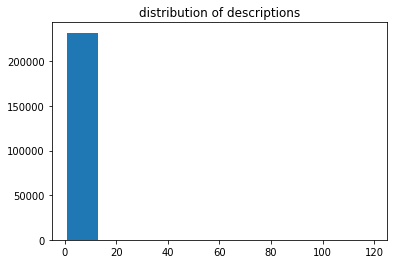

In [35]:
array = trainDF.groupby('descripcion').count().sort_values('precio',ascending=False)['id'].values;
plt.hist(array)
plt.title('distribution of descriptions')
plt.show()

_The information exctracted from the previous cells is that most descriptions are unique, as expected. However some company copy/pasted some descriptions and are also doing some fake discounts like 'para ti desde un 50-70% debajo de su avalúo'_

__To get further information, text mining will be needed.__

In [36]:
#word count in descriptions.
trainDF['word_count'] = trainDF['descripcion'].apply(lambda x: len(str(x).split(" ")))
trainDF[['descripcion','word_count']].head()

descripcion  word_count
0  depto. interior de 80.15m2, consta de sala com...          26
1  <p>entre sonora y guerrero, atr&aacute;s del h...          94
2  descripcion \nla mejor ubicacion residencial e...         211
3  casa en privada con caseta de vigilancia casas...          56
4  bonito departamento en excelentes condiciones ...          16

In [37]:
print("Most frequent words in descriptions")
pd.Series(''.join(str(trainDF["descripcion"])).lower().split()).value_counts()[:10]

Most frequent words in descriptions


en              39
de              23
casa            21
con             11
...             10
venta            8
departamento     7
excelente        6
terreno          5
y                5
dtype: int64

_As seen NLP is not an easy task. A usefull analysis for our context would be keyword extraction that is a field of research in itself._

---
## __Nan Values__
---
_When looking at data it is important to keep in mind that it can contain missing values._

_Dealing with those is paramount in order to work with our data._

                 numNanVal
titulo                5387
descripcion           1619
tipodepropiedad         46
direccion            53072
ciudad                 372
provincia              155
antiguedad           43555
habitaciones         22471
garages              37765
banos                26221
metroscubiertos      17400
metrostotales        51467
idzona               28621
lat                 123488
lng                 123488


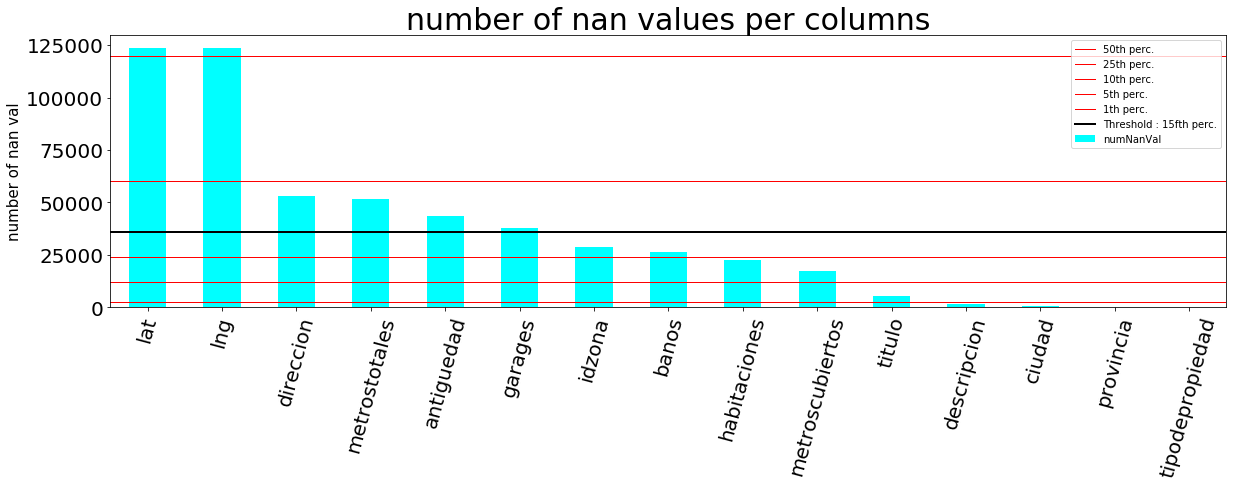

In [38]:
from pyspark.sql.functions import col, count, isnan, lit, sum
def count_not_null(c, nan_as_null=False):
    """Use conversion between boolean and integer
    - False -> 0
    - True -> 1
    """
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)

  
#dealing with missing values:
#where are they ?
fig, ax = plt.subplots(figsize=[20,5])


#total number of values
numVal = df.count()
nanValDF = df.agg(*[count_not_null(c) for c in df.columns]).toPandas().transpose()
nanValDF.columns = ['numNanVal']
#rectify the count
nanValDF['numNanVal'] = -1*nanValDF['numNanVal']+numVal
#filter the 0 values
nanValDF = nanValDF[nanValDF['numNanVal']>0]

print(nanValDF)
nanValDF.sort_values(by='numNanVal', ascending = False).plot(kind='bar', ax = ax, cmap='cool')
plt.tick_params(labelsize=20)
plt.ylabel("number of nan val", fontsize=15)
plt.xlabel(" ")
plt.title("number of nan values per columns", fontsize=30)


for i, quantile in enumerate([.01, 0.05, .1, .25, .5][::-1]):
    ax.axhline(numVal*quantile,c='r', linewidth=1, label='%.0fth perc.' %(quantile*100))
ax.axhline(numVal*0.15,c='black', linewidth=2, label='Threshold : 15fth perc.')

    
plt.legend()
plt.xticks(rotation = 75)
plt.show()

## __Normalization of the data__

---
_Most of the business analytics frameworks are tailor-made for working with Normally distributed data sets. Hence we should transform our data to follow that distribution if possible._

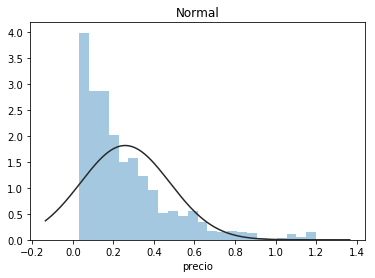

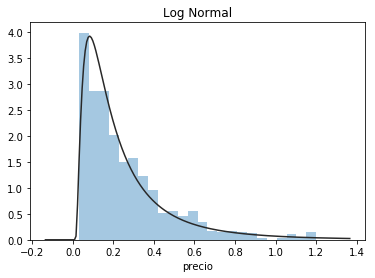

In [39]:
y = train['precio']/10**7
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)
plt.show()

In [40]:
#separate features in quantitative and qualitative for a separate analysis
quantitative = list(train.select_dtypes('number').columns)
quantitative.remove('id')
qualitative = train.select_dtypes('object').columns.values
qualitativeImportant = ['tipodepropiedad','provincia']

In [10]:
#test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
#normal = pd.DataFrame(train[quantitative])
#normal = normal.apply(test_normality)
#print(not normal.any())

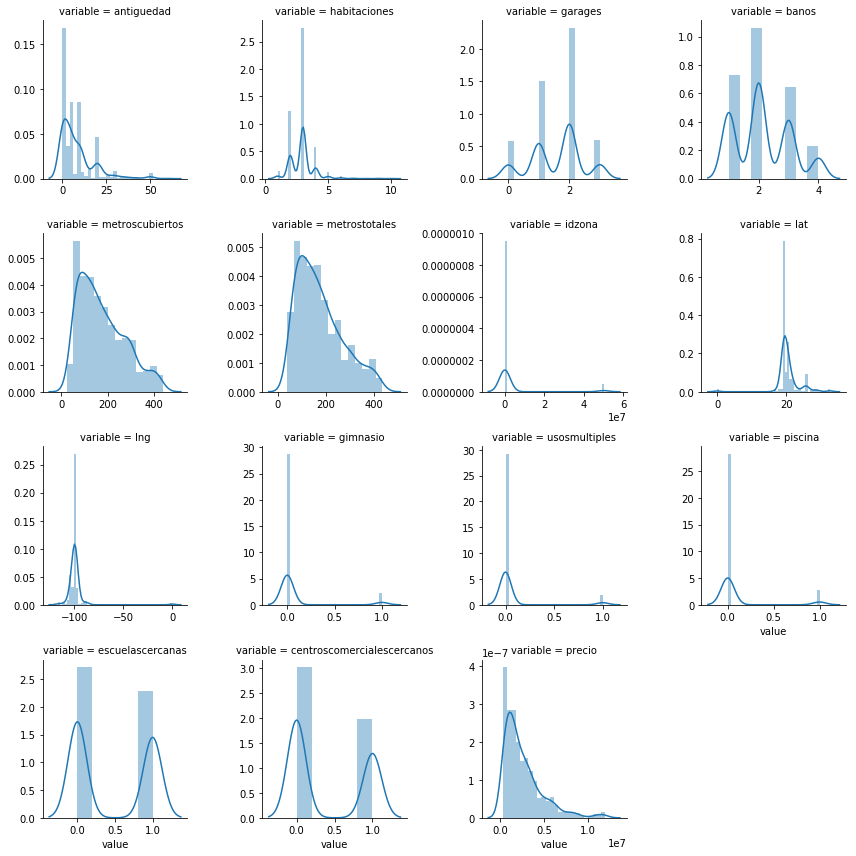

In [42]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

### Let's now have a look at the importance of the qualitative variable

In [43]:
anovaDF = train.copy().dropna()
anova = pd.DataFrame(columns = ['feature','pvalue'])
anova['feature'] = qualitativeImportant
for col in qualitativeImportant: #for each qualitative column we get the pvalues
    samples = []
    for elt in anovaDF[col].unique():
        samples.append(anovaDF['precio'][anovaDF[col] == elt].values)
    a = stats.f_oneway(*samples)
    anova['pvalue'][anova['feature']==col] = a.pvalue
    
#sort and cast
anova = anova.sort_values('pvalue')
anova['pvalue'] = anova['pvalue'].astype('float')
#transform for better visualisation and plot
anova['disparity'] = np.log(1./anova['pvalue'].values)

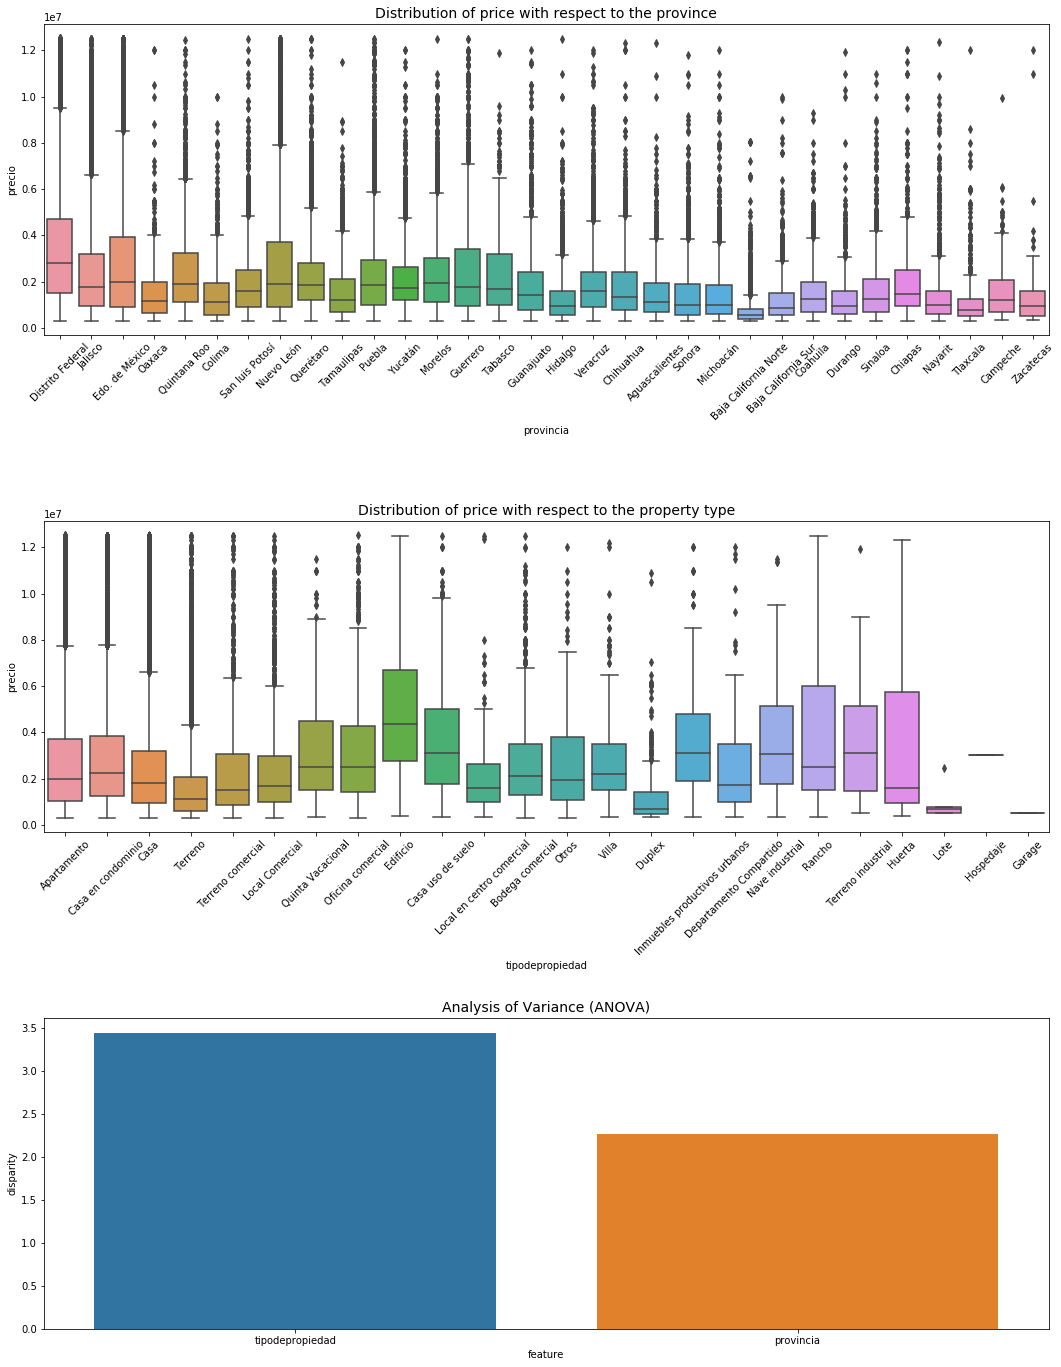

In [44]:
fig, ax = plt.subplots(figsize = [18,24], nrows = 3)
plt.subplots_adjust(hspace = 0.6)

ax[0].set_title('Distribution of price with respect to the province',fontsize = 14)
sns.boxplot(x= trainDF['provincia'], y=trainDF['precio'], ax = ax[0])
ax[0].tick_params(axis='x', rotation=45)

ax[1].set_title('Distribution of price with respect to the property type',fontsize = 14)
sns.boxplot(x= trainDF['tipodepropiedad'], y=trainDF['precio'], ax = ax[1])
ax[1].tick_params(axis='x', rotation=45)


ax[2].set_title('Analysis of Variance (ANOVA)', fontsize = 14)
sns.barplot(data=anova, x='feature', y='disparity', ax = ax[2])

plt.show()

Here with the analysis of variance we have an indication that the provincia is more impactfull on the saling price thant the property type.

---
## __Comparing Cities__
---
_The following plot compares the 7 cities with the most datapoints._

In [45]:
ciudadCountDF = trainDF.groupby('ciudad')['precio'].count().sort_values(ascending = False)
top10Cities = ciudadCountDF[:7].index
print('Cities with most data points:')
print(top10Cities.values)

top10DF = trainDF[trainDF['ciudad'].isin(top10Cities)].groupby('ciudad').mean().dropna()

Cities with most data points:
['Querétaro' 'Benito Juárez' 'Zapopan' 'San Luis Potosí' 'Mérida'
 'Monterrey' 'Alvaro Obregón']


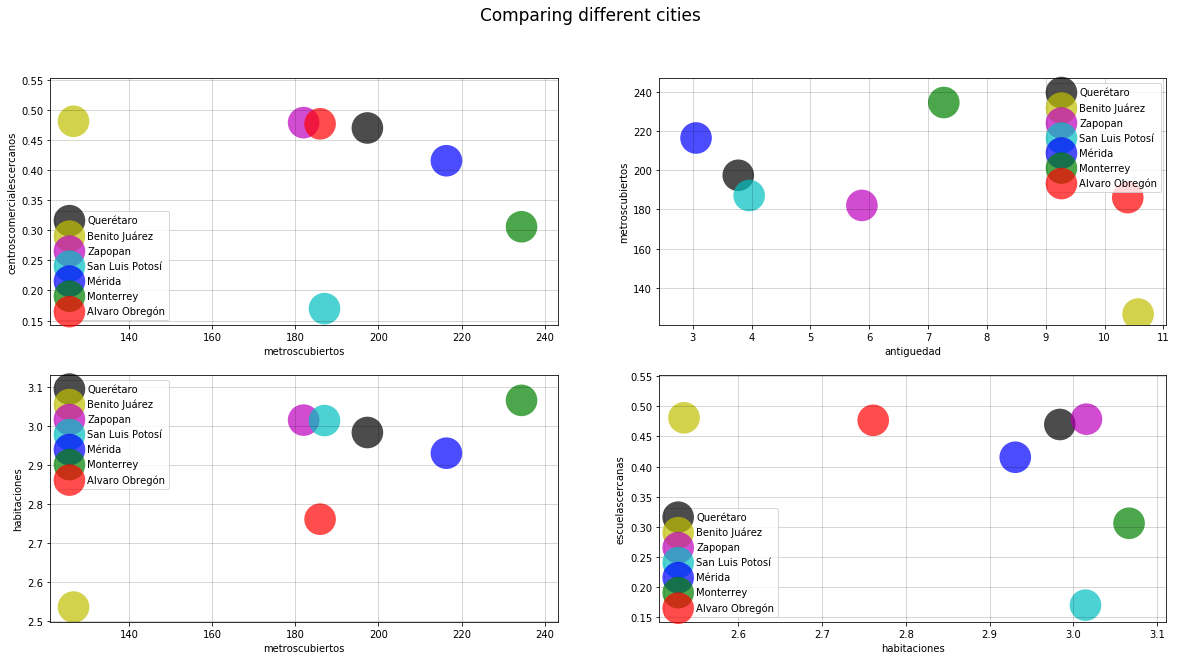

In [46]:
cl = ['r', 'g', 'b','c','m','y','k']
scale = 10**3
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [20,10])
currentAx  = ax[0][0]
colorList = cl.copy()
for city in top10Cities:
    currentAx.scatter(top10DF[top10DF.index == city]['metroscubiertos'], top10DF[top10DF.index == city]['escuelascercanas'],
               c=colorList.pop(), s=scale, label=city,
               alpha=0.7, edgecolors='none')
currentAx.legend()
currentAx.grid(True)
currentAx.set_xlabel('metroscubiertos')
currentAx.set_ylabel('centroscomercialescercanos')


currentAx  = ax[0][1]
colorList = cl.copy()
for city in top10Cities:
    currentAx.scatter(top10DF[top10DF.index == city]['antiguedad'], top10DF[top10DF.index == city]['metroscubiertos'],
               c=colorList.pop(), s=scale, label=city,
               alpha=0.7, edgecolors='none')
currentAx.legend()
currentAx.grid(True)
currentAx.set_xlabel('antiguedad')
currentAx.set_ylabel('metroscubiertos')


currentAx  = ax[1][0]
colorList = cl.copy()
for city in top10Cities:
    currentAx.scatter(top10DF[top10DF.index == city]['metroscubiertos'], top10DF[top10DF.index == city]['habitaciones'],
               c=colorList.pop(), s=scale, label=city,
               alpha=0.7, edgecolors='none')
currentAx.legend()
currentAx.grid(True)
currentAx.set_xlabel('metroscubiertos')
currentAx.set_ylabel('habitaciones')


currentAx  = ax[1][1]
colorList = cl.copy()
for city in top10Cities:
    currentAx.scatter(top10DF[top10DF.index == city]['habitaciones'], top10DF[top10DF.index == city]['escuelascercanas'],
               c=colorList.pop(), s=scale, label=city,
               alpha=0.7, edgecolors='none')
currentAx.legend()
currentAx.grid(True)
currentAx.set_xlabel('habitaciones')
currentAx.set_ylabel('escuelascercanas')

plt.suptitle('Comparing different cities', fontsize = 17)
plt.show()

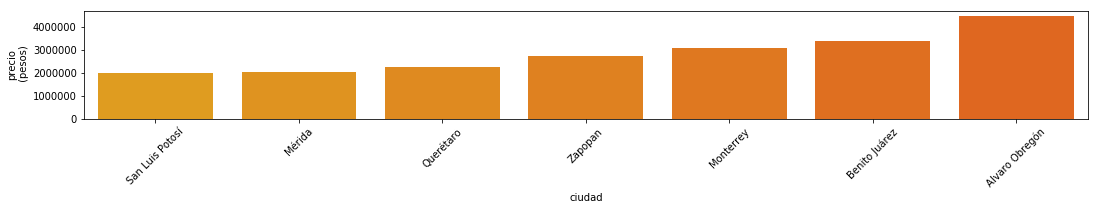

In [47]:
plt.figure(figsize = [18,2])
sns.barplot(x=top10DF.index, y="precio", data=top10DF, palette=colors,
            order=trainDF[trainDF['ciudad'].isin(top10Cities)].groupby('ciudad').
            mean().sort_values('precio').index)

result = top10DF.reset_index().sort_values('precio')
plt.ylabel('precio\n (pesos)')
plt.xticks(rotation = 45)
plt.show()

After examining the visuals, we can by example see that Benito Juarez is a special city that is to say not like the others. Effectively it has old properties and low ratio of habitaciones/metroscubiertos and more generaly a small number of habitaciones. It seems to be a dense city that did not renew its properties.